In [65]:
import os
import warnings
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from collections import deque
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp, chi2_contingency
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import random
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

In [66]:
# Suppress warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [67]:
import tensorflow as tf
print(tf.__version__)


# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

2.16.1


In [68]:
# Configure GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
#         print(f"Using GPU: {gpus[0].name}")
#         tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        print(f"Error configuring GPU: {e}")
else:
    print("No GPU available. Running on CPU.")

In [14]:
#Corrected code

import pandas as pd
import random
import numpy as np

class PatientDataEnv:
    def __init__(self, base_file):
        self.base_data = pd.read_csv(base_file)
        if 'Reward' not in self.base_data.columns:
            raise ValueError("Base data must contain a 'Reward' column")
        
        self.attributes = [
            'Age', 'Sex', 'Medical History', 'Preferred Exercise', 'Exercise Frequency', 
            'Exercise Duration', 'Race', 'Weekly Goal', 'Strength Training', 
            'Start Preference', 'Exercise Variety', 'Exercise Location', 'Exercise Buddy', 
            'Cardio Preference', 'Strength Preference', 'Coach Appearance'
        ]
        self.categorical_attributes = [
            'Sex', 'Medical History', 'Preferred Exercise', 'Exercise Duration', 'Race',
            'Exercise Location', 'Coach Appearance'
        ]
        self.numerical_attributes = [attr for attr in self.attributes if attr not in self.categorical_attributes and attr != 'Patient ID']
        
        self.attribute_values = {
            'Age': (18, 80),
            'Sex': ['Male', 'Female', 'Non-Binary', 'Prefer not to say'],
            'Medical History': ['diabetes', 'hypertension', 'COPD', 'high cholesterol', 'back pain', 'spondylitis',
                                'none', 'obesity', 'kidney disease', 'osteoarthritis', 'stroke', 'cardiac disease', 'Alzheimer’s'],
            'Exercise Frequency': (1, 7),
            'Preferred Exercise': ['cardio', 'strength', 'flexibility'],
            'Exercise Duration': ['30-45', '45-60', '0-15', '15-30', '60-75', '75-90', '90-105', '105-120'],
            'Race': ['White', 'Black', 'Asian', 'Hispanic', 'Other'],
            'Weekly Goal': (90, 210),
            'Strength Training': (0, 1),
            'Start Preference': (0, 1),
            'Exercise Variety': (0, 1),
            'Exercise Location': (0, 4),
            'Exercise Buddy': (0, 1),
            'Cardio Preference': (1, 10),
            'Strength Preference': (0, 1),
            'Coach Appearance': (1, 4)
        }
        
        self.state_size = len(self.numerical_attributes) + sum(len(self.attribute_values[attr]) if isinstance(self.attribute_values[attr], list) else 1 for attr in self.categorical_attributes)
        self.action_space = len(self.attributes)
        
        self.state = None
        self.reset()
    
    def reset(self):
        self.state = {}
        for attr in self.attributes:
            if attr in self.categorical_attributes:
                self.state[attr] = random.choice(self.attribute_values[attr]) if isinstance(self.attribute_values[attr], list) else random.randint(*self.attribute_values[attr])
            else:
                self.state[attr] = random.randint(*self.attribute_values[attr])
        return self.state_to_array()
    
    def state_to_array(self):
        state_array = []
        for attr in self.attributes:
            if attr in self.numerical_attributes or attr == 'Patient ID':
                min_val, max_val = self.attribute_values[attr]
                normalized_value = (self.state[attr] - min_val) / (max_val - min_val)
                state_array.append(normalized_value)
            elif attr in self.categorical_attributes:
                if isinstance(self.attribute_values[attr], list):
                    one_hot = [1 if self.state[attr] == cat else 0 for cat in self.attribute_values[attr]]
                    state_array.extend(one_hot)
                else:
                    min_val, max_val = self.attribute_values[attr]
                    normalized_value = (self.state[attr] - min_val) / (max_val - min_val)
                    state_array.append(normalized_value)
        return np.array(state_array, dtype=np.float32)
    
    def step(self, action):
        attribute = self.attributes[action]
        if attribute in self.categorical_attributes:
            if isinstance(self.attribute_values[attribute], list):
                value = random.choice(self.attribute_values[attribute])
            else:
                value = random.randint(*self.attribute_values[attribute])
        else:
            value = random.randint(*self.attribute_values[attribute])
        
        self.state[attribute] = value
        reward = self.calculate_reward()
        return self.state_to_array(), reward, False, {}
    
    def calculate_reward(self):
        frequency = self.state['Exercise Frequency']
        duration = self.state['Exercise Duration']
        duration_map = {'0-15': 1, '15-30': 2, '30-45': 3, '45-60': 4, '60-75': 5, '75-90': 6, '90-105': 7, '105-120': 8}
        
        base_reward = frequency * duration_map[duration] / 40  # Normalize to [0, 1]
        
        if self.state['Strength Training'] == 1:
            base_reward *= 1.1
        if self.state['Exercise Variety'] == 1:
            base_reward *= 1.05
        if self.state['Exercise Buddy'] == 1:
            base_reward *= 1.05
        
        return min(base_reward, 1.0)  # Cap reward at 1.0

In [15]:
class DQNAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001, discount_factor=0.95, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, batch_size=64, memory_size=10000):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.memory = deque(maxlen=memory_size)
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential([
            Dense(64, activation='relu', input_shape=(self.state_size,)),
            BatchNormalization(),
            Dense(64, activation='relu'),
            BatchNormalization(),
            Dense(self.action_size, activation='linear')
        ])
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state.reshape(1, -1), verbose=0)
        return np.argmax(act_values[0])

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        targets = rewards + self.discount_factor * np.amax(self.model.predict(next_states, verbose=0), axis=1) * (1 - dones)
        target_f = self.model.predict(states, verbose=0)
        target_f[np.arange(self.batch_size), actions] = targets

        history = self.model.fit(states, target_f, epochs=1, verbose=0, batch_size=self.batch_size)
        loss = history.history['loss'][0]

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return loss

Training DQN:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating Synthetic Data:   0%|          | 0/2000 [00:00<?, ?it/s]

Synthetic Data Shape: (2000, 16)

Synthetic Data Sample:
   Age         Sex   Medical History Preferred Exercise  Exercise Frequency  \
0   42        Male       Alzheimer’s        flexibility                   5   
1   76      Female          diabetes           strength                   3   
2   69  Non-Binary          diabetes           strength                   5   
3   57  Non-Binary       Alzheimer’s             cardio                   4   
4   71        Male  high cholesterol             cardio                   5   

  Exercise Duration      Race  Weekly Goal  Strength Training  \
0             45-60  Hispanic          185                  0   
1           105-120  Hispanic          189                  1   
2             75-90     Other          127                  1   
3             60-75     White          112                  0   
4             60-75     Black          109                  0   

   Start Preference  Exercise Variety  Exercise Location  Exercise Buddy  \
0

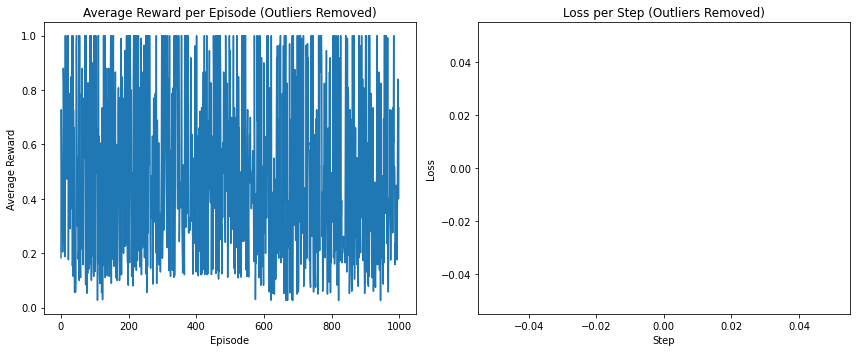

In [17]:
@tf.function
def train_step(model, states, target_f):
    with tf.GradientTape() as tape:
        predictions = model(states, training=True)
        loss = tf.keras.losses.MSE(target_f, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

def train_dqn(env, episodes, max_steps_per_episode):
    agent = DQNAgent(state_size=env.state_size, action_size=env.action_space)
    rewards_per_step = []
    losses = []
    episodes_list = []
    steps_list = []
    
    with tqdm(total=episodes, desc="Training DQN", leave=True) as pbar:
        for episode in range(episodes):
            state = env.reset()
            episode_rewards = []
            episode_losses = []
            
            for step in range(max_steps_per_episode):
                action = agent.act(state)
                next_state, reward, done, _ = env.step(action)
                agent.remember(state, action, reward, next_state, done)
                state = next_state
                
                rewards_per_step.append(reward)
                episodes_list.append(episode)
                steps_list.append(step)
                
                if len(agent.memory) > agent.batch_size:
                    loss = agent.replay()
                    if loss is not None:
                        losses.append(loss)
                        episode_losses.append(loss)
                
                if done or reward >= env.base_data['Reward'].max() * 0.5:
                    break
            
            avg_reward = np.mean(episode_rewards)
            avg_loss = np.mean(episode_losses) if episode_losses else 0
            
            pbar.update(1)
            pbar.set_postfix({"Avg Reward": f"{avg_reward:.2f}", "Epsilon": f"{agent.epsilon:.2f}", "Avg Loss": f"{avg_loss:.4f}"})
            
        # Save rewards and losses to CSV
    rewards_df = pd.DataFrame({
        'Episode': episodes_list,
        'Step': steps_list,
        'Reward': rewards_per_step
    })
    rewards_df.to_csv('rewards_per_step.csv', index=False)
    
    losses_df = pd.DataFrame({
        'Loss': losses
    })
    losses_df.to_csv('losses.csv', index=False)
    
    return agent, rewards_df, losses_df


def plot_training_metrics(rewards_df, losses_df):
    # Calculate rewards per episode
    rewards_per_episode = rewards_df.groupby('Episode')['Reward'].mean().values
    
    # Remove outliers
    def remove_outliers(data, m=2):
        return [x for x in data if (np.abs(x - np.mean(data)) < m * np.std(data))]
    
    rewards_without_outliers = remove_outliers(rewards_per_episode)
    losses_without_outliers = remove_outliers(losses_df['Loss'].values)
    
    # Plot rewards
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(rewards_without_outliers)
    plt.title('Average Reward per Episode (Outliers Removed)')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    
    # Plot losses
    plt.subplot(1, 2, 2)
    plt.plot(losses_without_outliers)
    plt.title('Loss per Step (Outliers Removed)')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    
    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.show()

# Main execution
env = PatientDataEnv('base_file_created_including guidelines.csv')
agent, rewards_df, losses_df = train_dqn(env, episodes=1000, max_steps_per_episode=100)

# Generate synthetic data
synthetic_data = generate_synthetic_data(env, agent, num_samples=2000)
print("Synthetic Data Shape:", synthetic_data.shape)
print("\nSynthetic Data Sample:")
print(synthetic_data.head())

# Save the synthetic data to a CSV file
output_file = 'synthetic_patient_data.csv'
synthetic_data.to_csv(output_file, index=False)
print(f"\nSynthetic data saved to {output_file}")

# Plot training metrics
plot_training_metrics(rewards_df, losses_df)

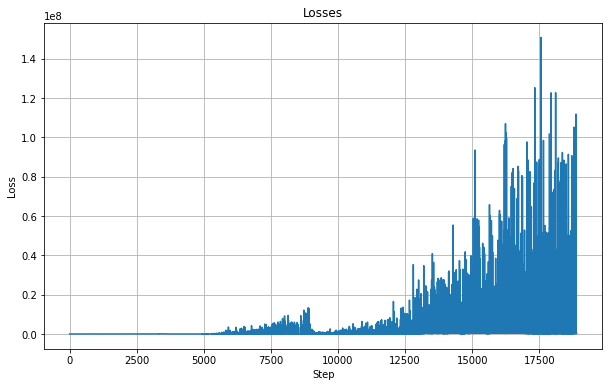

In [83]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the data from the CSV file
df = pd.read_csv('losses.csv')

plt.figure(figsize=(10, 6))

# Assuming the CSV has a column named 'Loss'
# If it's named differently, replace 'Loss' with the correct column name
plt.plot(df['Loss'])

plt.title('Losses')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.grid(True)

plt.show()


In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp, chi2_contingency
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Load the data
real_data = pd.read_csv('synthetic_data_generated_using_base_file_with_guidelines.csv')
synthetic_data = pd.read_csv('synthetic_patient_data.csv')

print("Columns in real data:", real_data.columns.tolist())
print("Columns in synthetic data:", synthetic_data.columns.tolist())

# Find common columns
common_columns = list(set(real_data.columns) & set(synthetic_data.columns))
print("\nCommon columns:", common_columns)

# Use only common columns
real_data = real_data[common_columns]
synthetic_data = synthetic_data[common_columns]

# Choose a target variable that exists in both datasets
target_column = 'Age'  # Change this to a suitable target variable that exists in both datasets

# Remove target variable from features
features = [col for col in common_columns if col != target_column]

# Identify numeric and categorical columns
numeric_features = real_data[features].select_dtypes(include=['int64', 'float64']).columns
categorical_features = real_data[features].select_dtypes(include=['object']).columns

print("\nNumeric features:", numeric_features.tolist())
print("Categorical features:", categorical_features.tolist())

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

def statistical_similarity(real_data, synthetic_data):
    numerical_columns = real_data.select_dtypes(include=[np.number]).columns
    categorical_columns = real_data.select_dtypes(include=['object']).columns
    
    similarity = {}
    
    for col in numerical_columns:
        ks_statistic, p_value = ks_2samp(real_data[col], synthetic_data[col])
        similarity[col] = {'ks_statistic': ks_statistic, 'p_value': p_value}
    
    for col in categorical_columns:
        real_counts = real_data[col].value_counts(normalize=True)
        synth_counts = synthetic_data[col].value_counts(normalize=True)
        all_categories = set(real_counts.index) | set(synth_counts.index)
        real_counts = real_counts.reindex(all_categories, fill_value=0)
        synth_counts = synth_counts.reindex(all_categories, fill_value=0)
        chi2, p_value, _, _ = chi2_contingency([real_counts, synth_counts])
        similarity[col] = {'chi2': chi2, 'p_value': p_value}
    
    return similarity

def distribution_comparison(real_data, synthetic_data):
    numerical_columns = real_data.select_dtypes(include=[np.number]).columns
    fig, axes = plt.subplots(len(numerical_columns), 1, figsize=(10, 5*len(numerical_columns)))
    
    if len(numerical_columns) == 1:
        axes = [axes]
    
    for i, col in enumerate(numerical_columns):
        sns.kdeplot(real_data[col], ax=axes[i], label='Real', shade=True)
        sns.kdeplot(synthetic_data[col], ax=axes[i], label='Synthetic', shade=True)
        axes[i].set_title(f'Distribution of {col}')
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()

def correlation_preservation(real_data, synthetic_data):
    numerical_columns = real_data.select_dtypes(include=[np.number]).columns
    
    real_corr = real_data[numerical_columns].corr()
    synth_corr = synthetic_data[numerical_columns].corr()
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(121)
    sns.heatmap(real_corr, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix - Real Data')
    
    plt.subplot(122)
    sns.heatmap(synth_corr, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix - Synthetic Data')
    
    plt.tight_layout()
    plt.show()
    
    return np.mean(np.abs(real_corr - synth_corr))

def privacy_preservation(real_data, synthetic_data):
    # Separate numerical and categorical columns
    numerical_columns = real_data.select_dtypes(include=['int64', 'float64']).columns
    categorical_columns = real_data.select_dtypes(include=['object']).columns
    
    # Create a ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_columns),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
        ])
    
    # Fit and transform the data
    real_scaled = preprocessor.fit_transform(real_data)
    synth_scaled = preprocessor.transform(synthetic_data)
    
    min_distances = []
    for synth_record in synth_scaled:
        distances = np.linalg.norm(real_scaled - synth_record, axis=1)
        min_distances.append(np.min(distances))
    
    return {'mean_min_distance': np.mean(min_distances), 'min_min_distance': np.min(min_distances)}

# Update the machine_learning_utility function similarly
def machine_learning_utility(real_data, synthetic_data):
    target_column = 'Age'  # Or another suitable numerical column
    print(f"Using '{target_column}' as the target variable.")
    
    X_real = real_data.drop(target_column, axis=1)
    y_real = real_data[target_column]
    X_synth = synthetic_data.drop(target_column, axis=1)
    y_synth = synthetic_data[target_column]
    
    # Combine real and synthetic data for preprocessing
    X_combined = pd.concat([X_real, X_synth], axis=0)
    
    # Create a ColumnTransformer for preprocessing
    numerical_columns = X_combined.select_dtypes(include=['int64', 'float64']).columns
    categorical_columns = X_combined.select_dtypes(include=['object']).columns
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_columns),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
        ])
    
    # Fit the preprocessor on the combined data
    preprocessor.fit(X_combined)
    
    # Transform real and synthetic data separately
    X_real_processed = preprocessor.transform(X_real)
    X_synth_processed = preprocessor.transform(X_synth)
    
    # Create and fit Random Forest on real data, test on synthetic
    rf_real = RandomForestClassifier(random_state=42)
    rf_real.fit(X_real_processed, y_real)
    real_on_synth_score = rf_real.score(X_synth_processed, y_synth)
    
    # Create and fit Random Forest on synthetic data, test on real
    rf_synth = RandomForestClassifier(random_state=42)
    rf_synth.fit(X_synth_processed, y_synth)
    synth_on_real_score = rf_synth.score(X_real_processed, y_real)
    
    return {'real_on_synth_score': real_on_synth_score, 'synth_on_real_score': synth_on_real_score}

def feature_importance_similarity(real_data, synthetic_data):
    target_column = 'Age'  # Or another suitable numerical column
    print(f"Using '{target_column}' as the target variable for feature importance.")
    
    X_real = real_data.drop(target_column, axis=1)
    y_real = real_data[target_column]
    X_synth = synthetic_data.drop(target_column, axis=1)
    y_synth = synthetic_data[target_column]
    
    # Combine real and synthetic data for preprocessing
    X_combined = pd.concat([X_real, X_synth], axis=0)
    
    # Create a ColumnTransformer for preprocessing
    numerical_columns = X_combined.select_dtypes(include=['int64', 'float64']).columns
    categorical_columns = X_combined.select_dtypes(include=['object']).columns
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_columns),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
        ])
    
    # Fit the preprocessor on the combined data
    preprocessor.fit(X_combined)
    
    # Transform real and synthetic data separately
    X_real_processed = preprocessor.transform(X_real)
    X_synth_processed = preprocessor.transform(X_synth)
    
    # Create and fit Random Forest on real data
    rf_real = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_real.fit(X_real_processed, y_real)
    real_importance = rf_real.feature_importances_
    
    # Create and fit Random Forest on synthetic data
    rf_synth = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_synth.fit(X_synth_processed, y_synth)
    synth_importance = rf_synth.feature_importances_
    
    # Calculate correlation between real and synthetic feature importances
    importance_similarity = np.corrcoef(real_importance, synth_importance)[0, 1]
    
    # Get feature names after preprocessing
    feature_names = (
        numerical_columns.tolist() +
        [f"{col}_{val}" for col, vals in zip(categorical_columns, preprocessor.named_transformers_['cat'].categories_) for val in vals]
    )
    
    # Plot feature importances
    plt.figure(figsize=(20, 10))
    x = range(len(real_importance))
    plt.bar(x, real_importance, alpha=0.5, label='Real Data', width=0.4)
    plt.bar([i+0.4 for i in x], synth_importance, alpha=0.5, label='Synthetic Data', width=0.4)
    plt.title('Feature Importance Comparison')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.legend()
    plt.xticks([i+0.2 for i in x], feature_names, rotation=90)
    plt.tight_layout()
    plt.show()
    
    return importance_similarity

def validate_synthetic_data(real_data, synthetic_data):
    metrics = {}
    
    metrics['statistical_similarity'] = statistical_similarity(real_data, synthetic_data)
    distribution_comparison(real_data, synthetic_data)
    metrics['correlation_preservation'] = correlation_preservation(real_data, synthetic_data)
    metrics['ml_utility'] = machine_learning_utility(real_data, synthetic_data)
    metrics['privacy_preservation'] = privacy_preservation(real_data, synthetic_data)
    metrics['feature_importance_similarity'] = feature_importance_similarity(real_data, synthetic_data)
    
    return metrics

Columns in real data: ['Patient ID', 'Age', 'Sex', 'Medical History', 'Exercise Frequency', 'Preferred Exercise', 'Exercise Duration', 'Race', 'Weekly Goal', 'Strength Training', 'Start Preference', 'Exercise Variety', 'Exercise Location', 'Exercise Buddy', 'Cardio Preference', 'Strength Preference', 'Coach Appearance']
Columns in synthetic data: ['Age', 'Sex', 'Medical History', 'Preferred Exercise', 'Exercise Frequency', 'Exercise Duration', 'Race', 'Weekly Goal', 'Strength Training', 'Start Preference', 'Exercise Variety', 'Exercise Location', 'Exercise Buddy', 'Cardio Preference', 'Strength Preference', 'Coach Appearance']

Common columns: ['Exercise Duration', 'Cardio Preference', 'Medical History', 'Race', 'Exercise Frequency', 'Start Preference', 'Strength Preference', 'Age', 'Preferred Exercise', 'Sex', 'Exercise Location', 'Exercise Buddy', 'Weekly Goal', 'Coach Appearance', 'Exercise Variety', 'Strength Training']

Numeric features: ['Cardio Preference', 'Exercise Frequency',

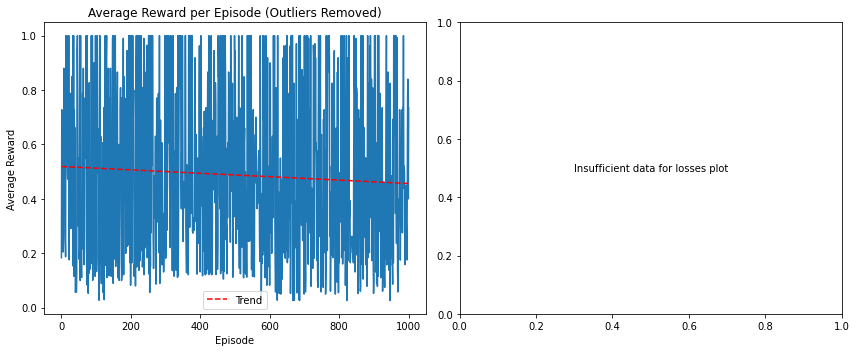

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

def plot_training_metrics(rewards_df, losses_df):
    # Calculate rewards per episode
    rewards_per_episode = rewards_df.groupby('Episode')['Reward'].mean().values
    
    # Remove outliers
    def remove_outliers(data, m=2):
        mean = np.mean(data)
        std = np.std(data)
        return [x for x in data if (np.abs(x - mean) < m * std)]
    
    rewards_without_outliers = remove_outliers(rewards_per_episode)
    losses_without_outliers = remove_outliers(losses_df['Loss'].values)
    
    plt.figure(figsize=(12, 5))
    
    # Plot rewards
    plt.subplot(1, 2, 1)
    if len(rewards_without_outliers) > 1:
        episodes = range(1, len(rewards_without_outliers) + 1)
        plt.plot(episodes, rewards_without_outliers)
        
        # Add trend line for rewards
        slope, intercept, _, _, _ = linregress(episodes, rewards_without_outliers)
        trend_line = slope * np.array(episodes) + intercept
        plt.plot(episodes, trend_line, color='red', linestyle='--', label='Trend')
        
        plt.title('Average Reward per Episode (Outliers Removed)')
        plt.xlabel('Episode')
        plt.ylabel('Average Reward')
        plt.legend()
    else:
        plt.text(0.5, 0.5, 'Insufficient data for rewards plot', ha='center', va='center')
    
    # Plot losses
    plt.subplot(1, 2, 2)
    if len(losses_without_outliers) > 1:
        steps = range(1, len(losses_without_outliers) + 1)
        plt.plot(steps, losses_without_outliers)
        
        # Add trend line for losses
        slope, intercept, _, _, _ = linregress(steps, losses_without_outliers)
        trend_line = slope * np.array(steps) + intercept
        plt.plot(steps, trend_line, color='red', linestyle='--', label='Trend')
        
        plt.title('Loss per Step (Outliers Removed)')
        plt.xlabel('Step')
        plt.ylabel('Loss')
        plt.legend()
    else:
        plt.text(0.5, 0.5, 'Insufficient data for losses plot', ha='center', va='center')
    
    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.show()

# Example usage:
rewards_df = pd.read_csv('rewards_per_step.csv')
losses_df = pd.read_csv('losses.csv')
plot_training_metrics(rewards_df, losses_df)

In [52]:
synthetic_data1 = pd.read_csv('synthetic_patient_data.csv')

In [53]:
synthetic_data1.head()

,Age,Sex,Medical History,Preferred Exercise,Exercise Frequency,Exercise Duration,Race,Weekly Goal,Strength Training,Start Preference,Exercise Variety,Exercise Location,Exercise Buddy,Cardio Preference,Strength Preference,Coach Appearance
0,42,Male,Alzheimer’s,flexibility,5,45-60,Hispanic,185,0,0,0,3,1,2,0,2
1,76,Female,diabetes,strength,3,105-120,Hispanic,189,1,0,1,4,1,2,1,2
2,69,Non-Binary,diabetes,strength,5,75-90,Other,127,1,1,0,4,0,10,0,1
3,57,Non-Binary,Alzheimer’s,cardio,4,60-75,White,112,0,0,1,2,0,3,1,3
4,71,Male,high cholesterol,cardio,5,60-75,Black,109,0,0,1,0,0,3,0,4


In [54]:
real_data.head()

,Exercise Duration,Medical History,Exercise Frequency,Age,Preferred Exercise,Sex
0,30-45,diabetes,1,18,cardio,Male
1,45-60,diabetes,1,18,cardio,Male
2,0-15,diabetes,1,18,cardio,Male
3,15-30,diabetes,1,18,cardio,Male
4,60-75,diabetes,1,18,cardio,Male


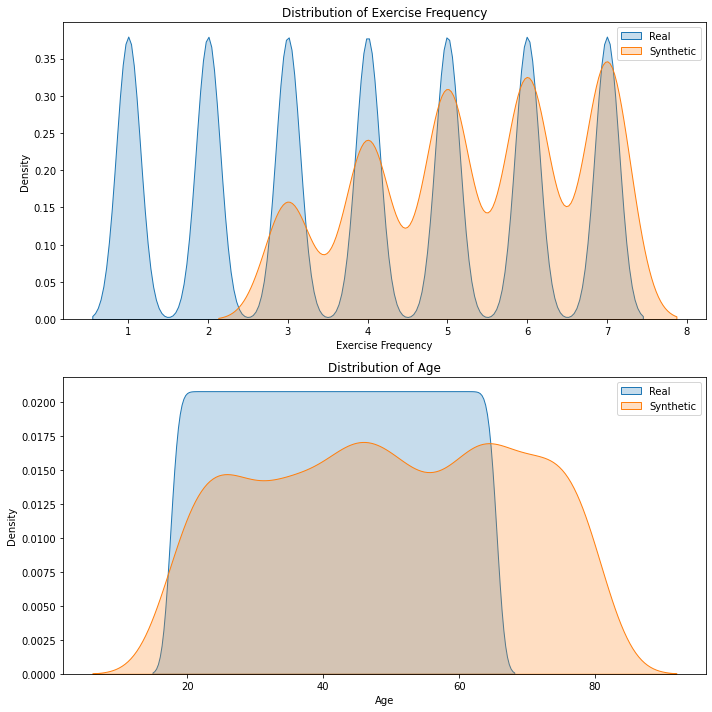

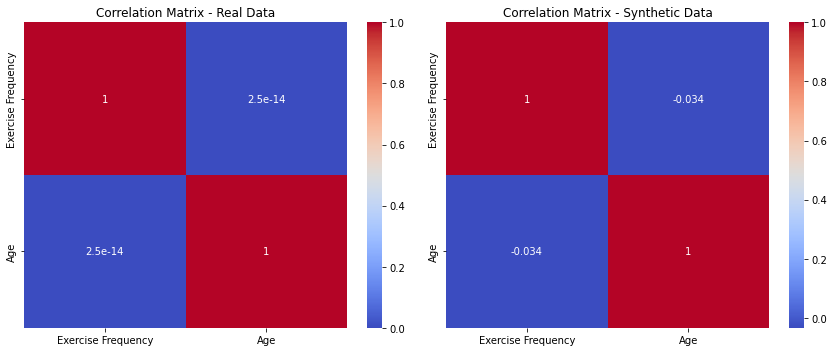

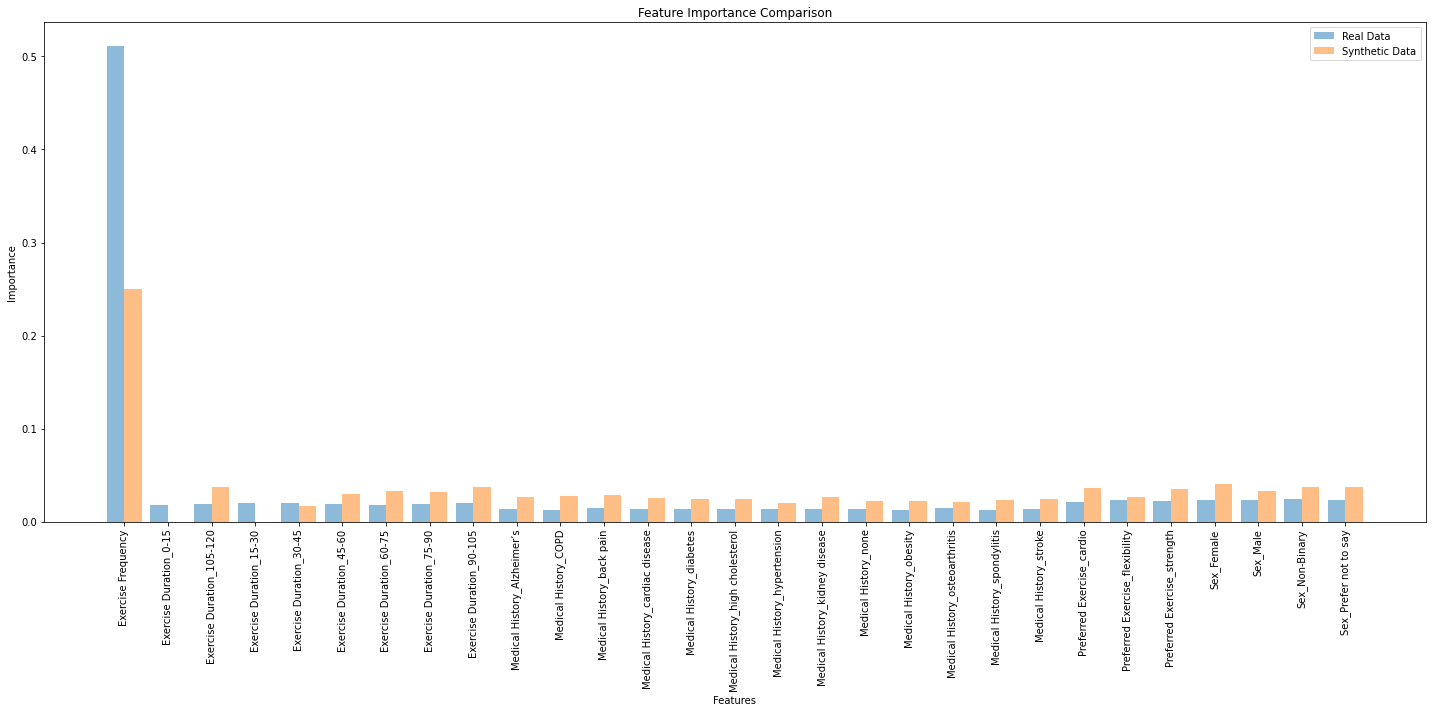


Validation Metrics:

Statistical Similarity:
{'Exercise Frequency': {'ks_statistic': 0.31407142857142856, 'p_value': 4.9098050064095736e-175}, 'Age': {'ks_statistic': 0.24650000000000005, 'p_value': 4.939754531158001e-107}, 'Exercise Duration': {'chi2': 0.346100753591177, 'p_value': 0.9998379263952465}, 'Medical History': {'chi2': 0.004741015299893955, 'p_value': 1.0}, 'Preferred Exercise': {'chi2': 0.000869866848731975, 'p_value': 0.9995651611454648}, 'Sex': {'chi2': 0.00016032435323845503, 'p_value': 0.9999994601200942}}

Correlation Preservation:
0.016774729145824032

Ml Utility:
{'real_on_synth_score': 0.017, 'synth_on_real_score': 0.015729929792429792}

Privacy Preservation:
{'mean_min_distance': 0.0, 'min_min_distance': 0.0}

Feature Importance Similarity:
0.9768986382514617


In [62]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import ks_2samp, chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
real_data = pd.read_csv('base_file_created_including guidelines_V1.csv')
synthetic_data = pd.read_csv('synthetic_patient_data.csv')

# Find common columns
common_columns = list(set(real_data.columns) & set(synthetic_data.columns))

# Use only common columns
real_data = real_data[common_columns]
synthetic_data = synthetic_data[common_columns]

# Choose a target variable that exists in both datasets
target_column = 'Age'  # Ensure this column exists in both datasets

# Remove target variable from features
features = [col for col in common_columns if col != target_column]

# Identify numeric and categorical columns
numeric_features = real_data[features].select_dtypes(include=['int64', 'float64']).columns
categorical_features = real_data[features].select_dtypes(include=['object']).columns

# Ensure categorical features are of string type
real_data[categorical_features] = real_data[categorical_features].astype(str)
synthetic_data[categorical_features] = synthetic_data[categorical_features].astype(str)

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Define validation functions
def statistical_similarity(real_data, synthetic_data):
    numerical_columns = real_data.select_dtypes(include=[np.number]).columns
    categorical_columns = real_data.select_dtypes(include=['object']).columns
    
    similarity = {}
    
    for col in numerical_columns:
        ks_statistic, p_value = ks_2samp(real_data[col], synthetic_data[col])
        similarity[col] = {'ks_statistic': ks_statistic, 'p_value': p_value}
    
    for col in categorical_columns:
        real_counts = real_data[col].value_counts(normalize=True)
        synth_counts = synthetic_data[col].value_counts(normalize=True)
        all_categories = set(real_counts.index) | set(synth_counts.index)
        real_counts = real_counts.reindex(all_categories, fill_value=0)
        synth_counts = synth_counts.reindex(all_categories, fill_value=0)
        chi2, p_value, _, _ = chi2_contingency([real_counts, synth_counts])
        similarity[col] = {'chi2': chi2, 'p_value': p_value}
    
    return similarity

def distribution_comparison(real_data, synthetic_data):
    numerical_columns = real_data.select_dtypes(include=[np.number]).columns
    fig, axes = plt.subplots(len(numerical_columns), 1, figsize=(10, 5*len(numerical_columns)))
    
    if len(numerical_columns) == 1:
        axes = [axes]
    
    for i, col in enumerate(numerical_columns):
        sns.kdeplot(real_data[col], ax=axes[i], label='Real', shade=True)
        sns.kdeplot(synthetic_data[col], ax=axes[i], label='Synthetic', shade=True)
        axes[i].set_title(f'Distribution of {col}')
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()

def correlation_preservation(real_data, synthetic_data):
    numerical_columns = real_data.select_dtypes(include=[np.number]).columns
    
    real_corr = real_data[numerical_columns].corr()
    synth_corr = synthetic_data[numerical_columns].corr()
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(121)
    sns.heatmap(real_corr, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix - Real Data')
    
    plt.subplot(122)
    sns.heatmap(synth_corr, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix - Synthetic Data')
    
    plt.tight_layout()
    plt.show()
    
    return np.mean(np.abs(real_corr - synth_corr))

def privacy_preservation(real_data, synthetic_data):
    # Fit and transform the real data to get the full set of columns
    real_scaled = preprocessor.fit_transform(real_data).toarray()
    
    # Transform the synthetic data, ensuring it has the same columns as real data
    synth_scaled = preprocessor.transform(synthetic_data).toarray()
    
    min_distances = []
    
    for synth_record in synth_scaled:
        # Compute distances from the synthetic record to all real records
        distances = np.linalg.norm(real_scaled - synth_record, axis=1)
        min_distances.append(np.min(distances))
    
    return {'mean_min_distance': np.mean(min_distances), 'min_min_distance': np.min(min_distances)}


def machine_learning_utility(real_data, synthetic_data):
    target_column = 'Age'
    X_real = real_data.drop(target_column, axis=1)
    y_real = real_data[target_column]
    X_synth = synthetic_data.drop(target_column, axis=1)
    y_synth = synthetic_data[target_column]

    # Combine real and synthetic data for preprocessing
    X_combined = pd.concat([X_real, X_synth], axis=0)

    # Fit the preprocessor on the combined data
    preprocessor.fit(X_combined)

    # Ensure X_real and X_synth have the same columns as X_combined
    X_real = X_real.reindex(columns=X_combined.columns, fill_value=0)
    X_synth = X_synth.reindex(columns=X_combined.columns, fill_value=0)

    # Transform real and synthetic data separately
    X_real_processed = preprocessor.transform(X_real)
    X_synth_processed = preprocessor.transform(X_synth)

    # Create and fit Random Forest on real data, test on synthetic
    rf_real = RandomForestClassifier(random_state=42)
    rf_real.fit(X_real_processed, y_real)
    real_on_synth_score = rf_real.score(X_synth_processed, y_synth)

    # Create and fit Random Forest on synthetic data, test on real
    rf_synth = RandomForestClassifier(random_state=42)
    rf_synth.fit(X_synth_processed, y_synth)
    synth_on_real_score = rf_synth.score(X_real_processed, y_real)

    return {'real_on_synth_score': real_on_synth_score, 'synth_on_real_score': synth_on_real_score}

def feature_importance_similarity(real_data, synthetic_data):
    target_column = 'Age'  # Or another suitable numerical column
    
    X_real = real_data.drop(target_column, axis=1)
    y_real = real_data[target_column]
    X_synth = synthetic_data.drop(target_column, axis=1)
    y_synth = synthetic_data[target_column]
    
    # Combine real and synthetic data for preprocessing
    X_combined = pd.concat([X_real, X_synth], axis=0)
    
    # Fit the preprocessor on the combined data
    preprocessor.fit(X_combined)
    
    # Transform real and synthetic data separately
    X_real_processed = preprocessor.transform(X_real)
    X_synth_processed = preprocessor.transform(X_synth)
    
    # Create and fit Random Forest on real data
    rf_real = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_real.fit(X_real_processed, y_real)
    real_importance = rf_real.feature_importances_
    
    # Create and fit Random Forest on synthetic data
    rf_synth = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_synth.fit(X_synth_processed, y_synth)
    synth_importance = rf_synth.feature_importances_
    
    # Calculate correlation between real and synthetic feature importances
    importance_similarity = np.corrcoef(real_importance, synth_importance)[0, 1]
    
    # Get feature names after preprocessing
    feature_names = (
        numeric_features.tolist() +
        [f"{col}_{val}" for col, vals in zip(categorical_features, preprocessor.named_transformers_['cat'].categories_) for val in vals]
    )
    
    # Plot feature importances
    plt.figure(figsize=(20, 10))
    x = range(len(real_importance))
    plt.bar(x, real_importance, alpha=0.5, label='Real Data', width=0.4)
    plt.bar([i+0.4 for i in x], synth_importance, alpha=0.5, label='Synthetic Data', width=0.4)
    plt.title('Feature Importance Comparison')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.legend()
    plt.xticks([i+0.2 for i in x], feature_names, rotation=90)
    plt.tight_layout()
    plt.show()
    
    return importance_similarity

# Validate synthetic data
def validate_synthetic_data(real_data, synthetic_data):
    metrics = {}
    
    metrics['statistical_similarity'] = statistical_similarity(real_data, synthetic_data)
    distribution_comparison(real_data, synthetic_data)
    metrics['correlation_preservation'] = correlation_preservation(real_data, synthetic_data)
    metrics['ml_utility'] = machine_learning_utility(real_data, synthetic_data)
    metrics['privacy_preservation'] = privacy_preservation(real_data, synthetic_data)
    metrics['feature_importance_similarity'] = feature_importance_similarity(real_data, synthetic_data)
    
    return metrics

# Run the validation
validation_metrics = validate_synthetic_data(real_data, synthetic_data)

print("\nValidation Metrics:")
for metric, value in validation_metrics.items():
    print(f"\n{metric.replace('_', ' ').title()}:")
    print(value)


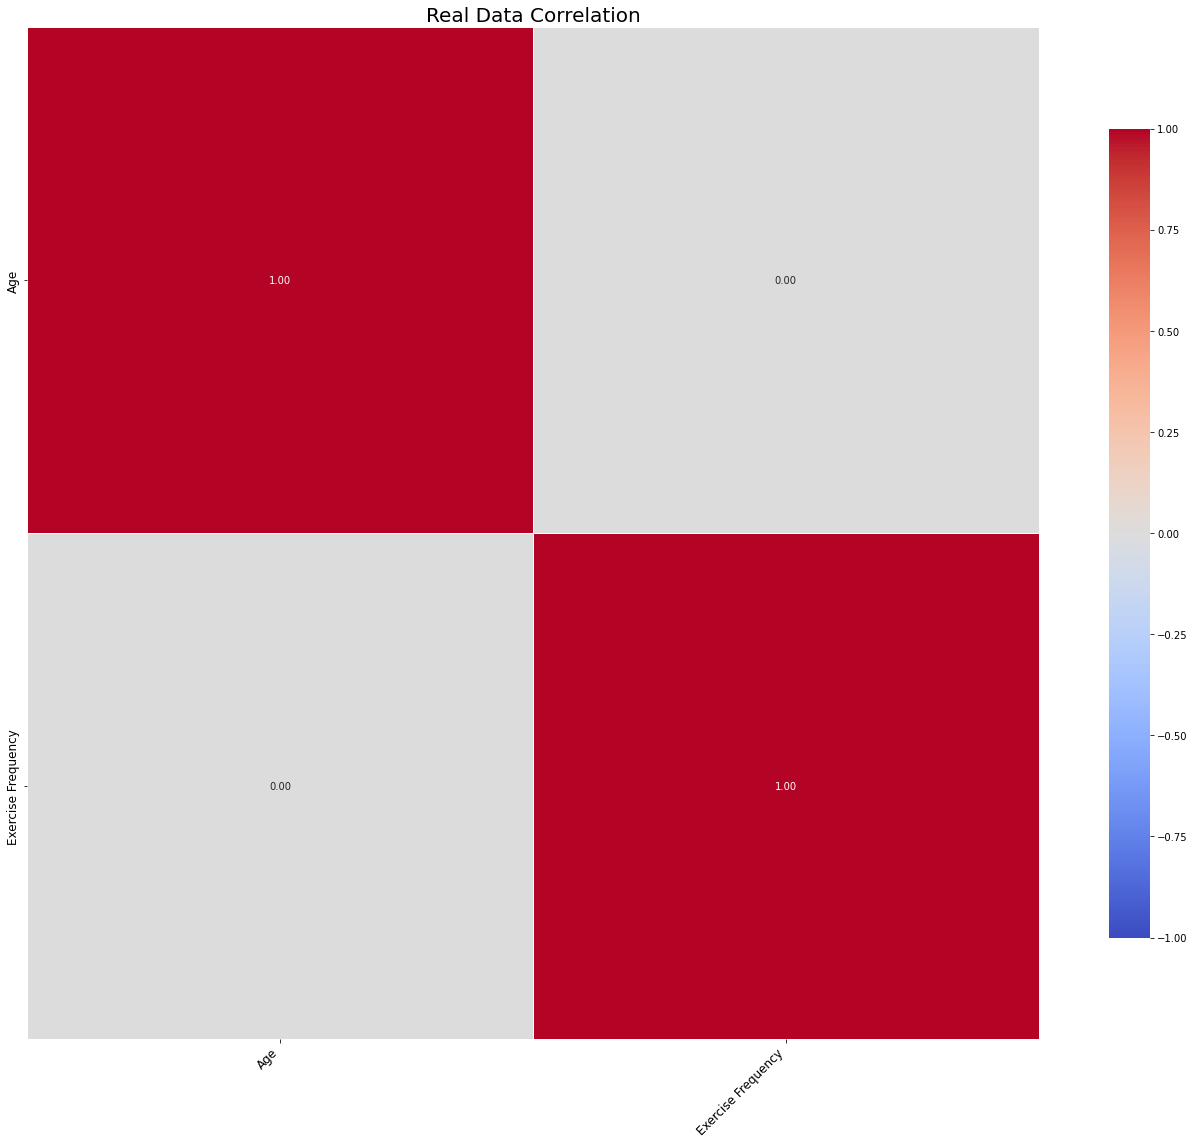

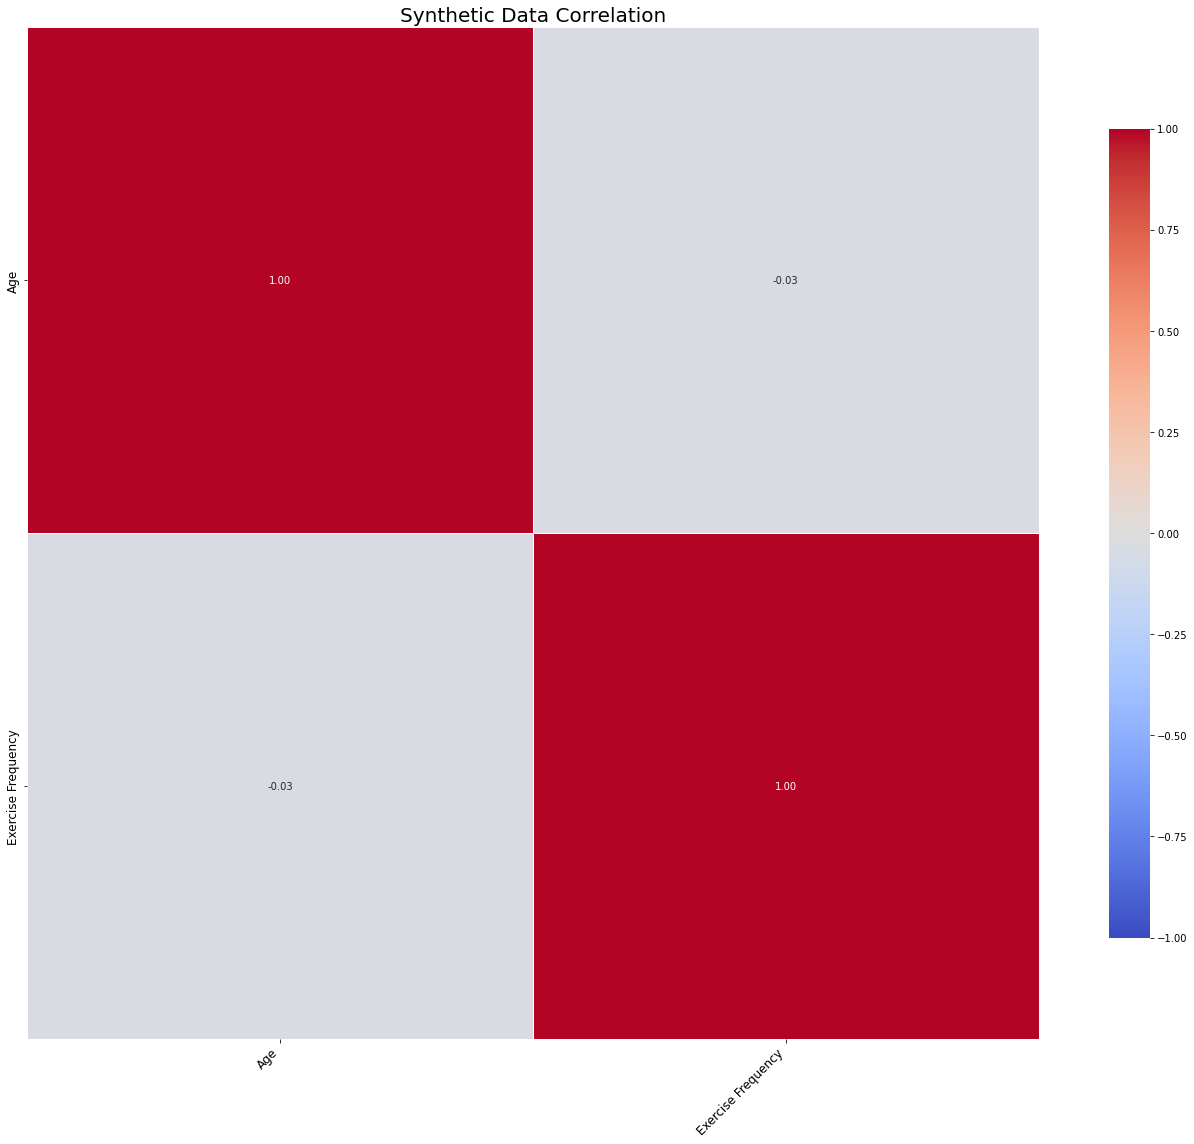

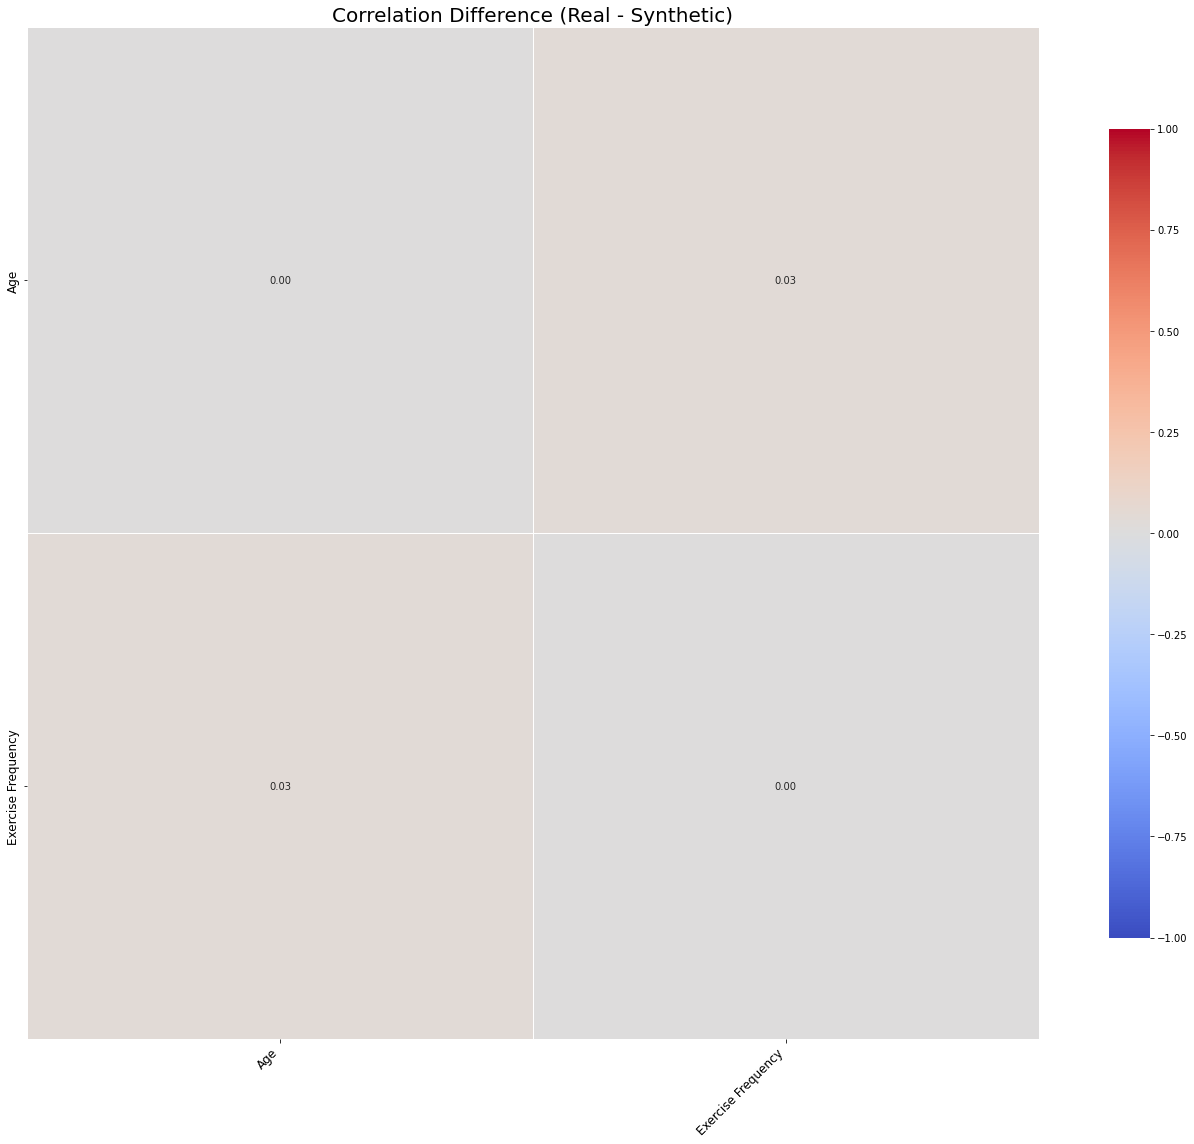

Mean absolute difference in correlations: 0.0168
Maximum absolute difference in correlations: 0.0335

Largest difference in correlation:
Features: Age and Exercise Frequency
Real correlation: 0.0000
Synthetic correlation: -0.0335
Difference: 0.0335

Excluded non-numeric columns:
Exercise Duration, Sex, Medical History, Preferred Exercise


In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def compare_correlations(real_data, synthetic_data):
    # Select only numeric columns
    real_numeric = real_data.select_dtypes(include=[np.number])
    synth_numeric = synthetic_data.select_dtypes(include=[np.number])
    
    # Ensure both dataframes have the same columns
    common_columns = list(set(real_numeric.columns) & set(synth_numeric.columns))
    real_numeric = real_numeric[common_columns]
    synth_numeric = synth_numeric[common_columns]
    
    # Compute correlation matrices
    real_corr = real_numeric.corr()
    synth_corr = synth_numeric.corr()
    
    # Compute difference in correlations
    diff_corr = real_corr - synth_corr
    
    # Plotting function for individual correlation matrices
    def plot_correlation(corr_matrix, title):
        plt.figure(figsize=(20, 16))
        sns.heatmap(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1, center=0, annot=True, fmt='.2f', 
                    square=True, linewidths=.5, cbar_kws={"shrink": .8})
        plt.title(title, fontsize=20)
        plt.xticks(rotation=45, ha='right', fontsize=12)
        plt.yticks(fontsize=12)
        plt.tight_layout()
        plt.show()
    
    # Plot individual correlation matrices
    plot_correlation(real_corr, 'Real Data Correlation')
    plot_correlation(synth_corr, 'Synthetic Data Correlation')
    plot_correlation(diff_corr, 'Correlation Difference (Real - Synthetic)')
    
    # Compute summary statistics
    mean_abs_diff = np.mean(np.abs(diff_corr))
    max_abs_diff = np.max(np.abs(diff_corr))
    
    print(f"Mean absolute difference in correlations: {mean_abs_diff:.4f}")
    print(f"Maximum absolute difference in correlations: {max_abs_diff:.4f}")
    
    # Find the pair of features with the largest difference in correlation
    max_diff_idx = np.unravel_index(np.argmax(np.abs(diff_corr)), diff_corr.shape)
    feature1, feature2 = diff_corr.index[max_diff_idx[0]], diff_corr.columns[max_diff_idx[1]]
    max_diff = diff_corr.iloc[max_diff_idx]
    
    print(f"\nLargest difference in correlation:")
    print(f"Features: {feature1} and {feature2}")
    print(f"Real correlation: {real_corr.loc[feature1, feature2]:.4f}")
    print(f"Synthetic correlation: {synth_corr.loc[feature1, feature2]:.4f}")
    print(f"Difference: {max_diff:.4f}")
    
    # Print excluded columns
    excluded_columns = set(real_data.columns) - set(common_columns)
    if excluded_columns:
        print("\nExcluded non-numeric columns:")
        print(", ".join(excluded_columns))

# Usage:
compare_correlations(real_data, synthetic_data1)

In [33]:
real_data = pd.read_csv('base_file_created_including guidelines_V1.csv')
synthetic_data1 = pd.read_csv('synthetic_patient_data.csv')

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

def compare_ml_models(real_data, synthetic_data, target_column='Age'):
    # Find common columns
    common_columns = list(set(real_data.columns) & set(synthetic_data.columns))
    print(f"Common columns: {common_columns}")
    
    if target_column not in common_columns:
        raise ValueError(f"Target column '{target_column}' not found in common columns")
    
    # Use only common columns
    real_data = real_data[common_columns]
    synthetic_data = synthetic_data[common_columns]
    
    # Separate features and target
    X_real = real_data.drop(target_column, axis=1)
    y_real = real_data[target_column]
    X_synth = synthetic_data.drop(target_column, axis=1)
    y_synth = synthetic_data[target_column]

    # Identify numeric and categorical columns
    numeric_features = X_real.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X_real.select_dtypes(include=['object', 'category']).columns

    print(f"Numeric features: {numeric_features.tolist()}")
    print(f"Categorical features: {categorical_features.tolist()}")

    # Create preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])

    # Create pipelines
    models = {
        'Linear Regression': Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', LinearRegression())
        ]),
        'Random Forest': Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
        ])
    }

    for model_name, model in models.items():
        print(f"\n{model_name} Results:")
        
        # Train on real, test on synthetic
        model.fit(X_real, y_real)
        y_pred = model.predict(X_synth)
        mse = mean_squared_error(y_synth, y_pred)
        r2 = r2_score(y_synth, y_pred)
        print(f"Real on Synthetic - MSE: {mse:.4f}, R2: {r2:.4f}")

        # Train on synthetic, test on real
        model.fit(X_synth, y_synth)
        y_pred = model.predict(X_real)
        mse = mean_squared_error(y_real, y_pred)
        r2 = r2_score(y_real, y_pred)
        print(f"Synthetic on Real - MSE: {mse:.4f}, R2: {r2:.4f}")

# Usage
compare_ml_models(real_data, synthetic_data1)

Common columns: ['Exercise Duration', 'Medical History', 'Exercise Frequency', 'Age', 'Preferred Exercise', 'Sex']
Numeric features: ['Exercise Frequency']
Categorical features: ['Exercise Duration', 'Medical History', 'Preferred Exercise', 'Sex']

Linear Regression Results:
Real on Synthetic - MSE: 400.1860, R2: -0.2007
Synthetic on Real - MSE: 270.4206, R2: -0.4091

Random Forest Results:
Real on Synthetic - MSE: 400.3229, R2: -0.2011
Synthetic on Real - MSE: 318.0060, R2: -0.6570


Common columns: ['Exercise Duration', 'Medical History', 'Exercise Frequency', 'Age', 'Preferred Exercise', 'Sex']
Numeric features: ['Exercise Frequency']
Categorical features: ['Exercise Duration', 'Medical History', 'Preferred Exercise', 'Sex']


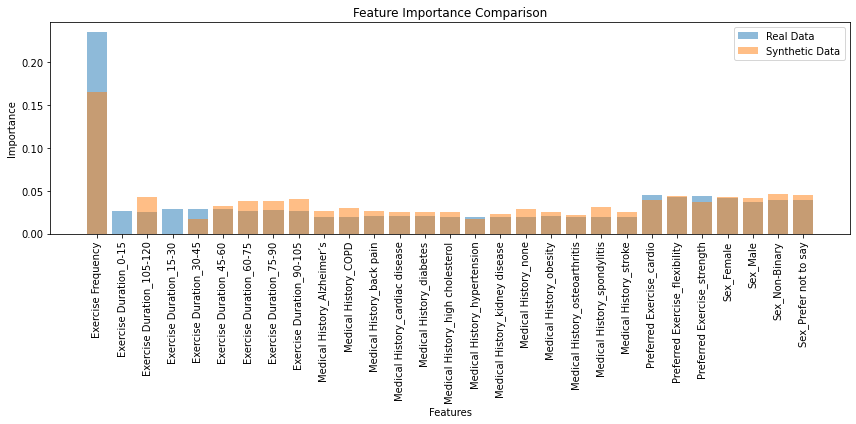

Correlation between real and synthetic feature importances: 0.9315

Top 10 features (Real Data):
['Exercise Frequency', 'Preferred Exercise_cardio', 'Preferred Exercise_strength', 'Preferred Exercise_flexibility', 'Sex_Female', 'Sex_Non-Binary', 'Sex_Prefer not to say', 'Sex_Male', 'Exercise Duration_15-30', 'Exercise Duration_30-45']

Top 10 features (Synthetic Data):
['Exercise Frequency', 'Sex_Non-Binary', 'Sex_Prefer not to say', 'Preferred Exercise_flexibility', 'Exercise Duration_105-120', 'Sex_Female', 'Sex_Male', 'Exercise Duration_90-105', 'Preferred Exercise_cardio', 'Exercise Duration_60-75']


In [35]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def compare_feature_importance(real_data, synthetic_data, target_column='Age'):
    # Find common columns
    common_columns = list(set(real_data.columns) & set(synthetic_data.columns))
    print(f"Common columns: {common_columns}")
    
    if target_column not in common_columns:
        raise ValueError(f"Target column '{target_column}' not found in common columns")
    
    # Use only common columns
    real_data = real_data[common_columns]
    synthetic_data = synthetic_data[common_columns]
    
    X_real = real_data.drop(target_column, axis=1)
    y_real = real_data[target_column]
    X_synth = synthetic_data.drop(target_column, axis=1)
    y_synth = synthetic_data[target_column]

    # Identify numeric and categorical columns
    numeric_features = X_real.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X_real.select_dtypes(include=['object', 'category']).columns
    print(f"Numeric features: {numeric_features.tolist()}")
    print(f"Categorical features: {categorical_features.tolist()}")

    # Create preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])

    # Create pipeline
    rf = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
    ])

    # Function to get feature names
    def get_feature_names(column_transformer):
        feature_names = []
        for name, pipe, features in column_transformer.transformers_:
            if name == 'cat':
                for i, feature in enumerate(features):
                    for category in pipe.categories_[i]:
                        feature_names.append(f"{feature}_{category}")
            else:
                feature_names.extend(features)
        return feature_names

    # Fit on real data
    rf.fit(X_real, y_real)
    feature_importance_real = rf.named_steps['regressor'].feature_importances_
    feature_names_real = get_feature_names(rf.named_steps['preprocessor'])

    # Fit on synthetic data
    rf.fit(X_synth, y_synth)
    feature_importance_synth = rf.named_steps['regressor'].feature_importances_
    feature_names_synth = get_feature_names(rf.named_steps['preprocessor'])

    # Create DataFrames
    importance_real = pd.DataFrame({'feature': feature_names_real, 'importance': feature_importance_real})
    importance_synth = pd.DataFrame({'feature': feature_names_synth, 'importance': feature_importance_synth})

    # Merge the DataFrames
    importance_combined = importance_real.merge(importance_synth, on='feature', how='outer', suffixes=('_real', '_synth'))
    importance_combined = importance_combined.fillna(0)  # Fill NaN with 0 for features not present in one of the datasets

    # Plot
    plt.figure(figsize=(12, 6))
    x = range(len(importance_combined))
    plt.bar(x, importance_combined['importance_real'], alpha=0.5, label='Real Data')
    plt.bar(x, importance_combined['importance_synth'], alpha=0.5, label='Synthetic Data')
    plt.title('Feature Importance Comparison')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.legend()
    plt.xticks(x, importance_combined['feature'], rotation=90)
    plt.tight_layout()
    plt.show()

    # Calculate correlation between real and synthetic feature importances
    correlation = np.corrcoef(importance_combined['importance_real'], importance_combined['importance_synth'])[0, 1]
    print(f"Correlation between real and synthetic feature importances: {correlation:.4f}")

    # Print top 10 features for each dataset
    print("\nTop 10 features (Real Data):")
    print(importance_combined.sort_values('importance_real', ascending=False)['feature'].head(10).tolist())
    print("\nTop 10 features (Synthetic Data):")
    print(importance_combined.sort_values('importance_synth', ascending=False)['feature'].head(10).tolist())

# Usage
compare_feature_importance(real_data, synthetic_data1)